In [2]:
from matplotlib import pyplot as plt
import numpy as np
import joblib
import os
import pandas as pd
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import numpy as np

import numpy as np
import pandas as pd
import joblib

from calimera import CALIMERA

from sklearn.metrics import accuracy_score



In [8]:

def load_bugsense_data():
    data = pd.read_csv('/media/storage/users/go98kef/TimeSeriesConversion/time_series_data.csv', header=None)
    labels = pd.read_csv('/media/storage/users/go98kef/TimeSeriesConversion/time_series_labels.csv', header=None)

    # Calculate number of complete groups of 80
    n_samples = len(data) // 80

    # Reshape data into groups of 80
    data_grouped = data.values.reshape(n_samples, 80, 24).transpose(0, 2, 1)
    labels_grouped = labels.values[::80]  # Take every 80th label

    # Generate random split indices (70% train, 30% test)
    train_size = int(0.7 * n_samples)
    test = int(0.3 * n_samples/2)
    indices = np.random.permutation(n_samples)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size+test]
    test_indices = indices[train_size+test:]
    

    # Split data and labels
    X_train = data_grouped[train_indices]
    X_test = data_grouped[test_indices]
    y_train = labels_grouped[train_indices]
    y_test = labels_grouped[test_indices]
    X_val = data_grouped[val_indices]
    y_val = labels_grouped[val_indices]


    return X_train, y_train.squeeze(), X_val, y_val.squeeze(), X_test, y_test.squeeze()


In [9]:
if __name__ == '__main__':
    X_train, y_train, X_val, y_val, X_test, y_test = load_bugsense_data()
    accuracy_scores = []
    earliness_scores = []
    cost_scores = []
    
    for delay_penalty in range(1,11):
        model = CALIMERA(delay_penalty=delay_penalty/10)
        model.fit(X_train, y_train)

        stop_timestamps, y_pred = model.test(X_val)
        
        accuracy = accuracy_score(y_val, y_pred)
        earliness = sum(stop_timestamps) / (X_test.shape[-1] * X_test.shape[0])
        cost = 1.0 - accuracy + delay_penalty/10 * earliness
        print(f'Accuracy: {accuracy}\nEarliness: {earliness}\nCost: {cost}')

        accuracy_scores.append(accuracy)
        earliness_scores.append(earliness)
        cost_scores.append(cost)
        model_filename = f'saved_models/calimera_model_delay_{delay_penalty / 10}.joblib'
        joblib.dump(model, model_filename)
    

    print(f'Accuracy scores: {accuracy_scores}')
    print(f'Earliness scores: {earliness_scores}')
    print(f'Cost scores: {cost_scores}')

/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(

Accuracy: 0.9642857142857143
Earliness: 0.4504166666666667
Cost: 0.08075595238095237


/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(

Accuracy: 0.8928571428571429
Earliness: 0.4345833333333333
Cost: 0.19405952380952377


/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(

Accuracy: 0.8928571428571429
Earliness: 0.3958333333333333
Cost: 0.2258928571428571


/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(

Accuracy: 0.8928571428571429
Earliness: 0.39208333333333334
Cost: 0.2639761904761905


/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(

Accuracy: 0.7857142857142857
Earliness: 0.33416666666666667
Cost: 0.38136904761904766


/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(

Accuracy: 0.8214285714285714
Earliness: 0.3383333333333333
Cost: 0.38157142857142856


/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(

Accuracy: 0.75
Earliness: 0.31083333333333335
Cost: 0.46758333333333335


/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(

Accuracy: 0.7142857142857143
Earliness: 0.25
Cost: 0.4857142857142857


/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(

Accuracy: 0.6071428571428571
Earliness: 0.24083333333333334
Cost: 0.6096071428571429


/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(

Accuracy: 0.6428571428571429
Earliness: 0.21958333333333332
Cost: 0.5767261904761904
Accuracy scores: [0.9642857142857143, 0.8928571428571429, 0.8928571428571429, 0.8928571428571429, 0.7857142857142857, 0.8214285714285714, 0.75, 0.7142857142857143, 0.6071428571428571, 0.6428571428571429]
Earliness scores: [0.4504166666666667, 0.4345833333333333, 0.3958333333333333, 0.39208333333333334, 0.33416666666666667, 0.3383333333333333, 0.31083333333333335, 0.25, 0.24083333333333334, 0.21958333333333332]
Cost scores: [0.08075595238095237, 0.19405952380952377, 0.2258928571428571, 0.2639761904761905, 0.38136904761904766, 0.38157142857142856, 0.46758333333333335, 0.4857142857142857, 0.6096071428571429, 0.5767261904761904]


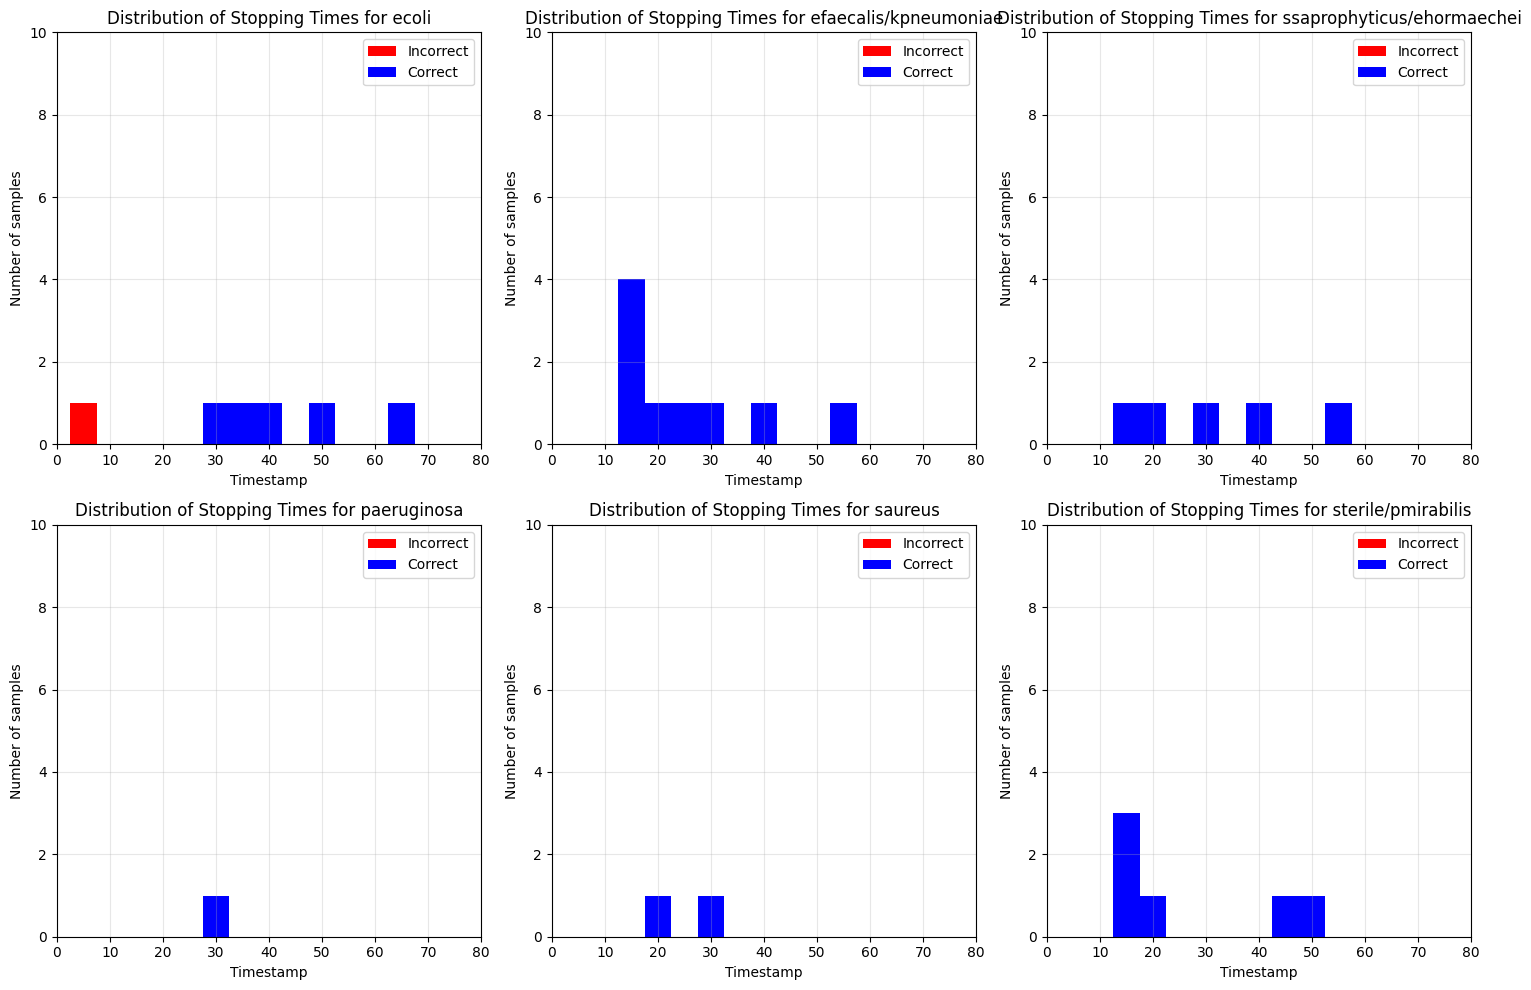

Accuracy: 0.9666666666666667
Earliness: 0.40541666666666665
Cost: 0.03738749999999999


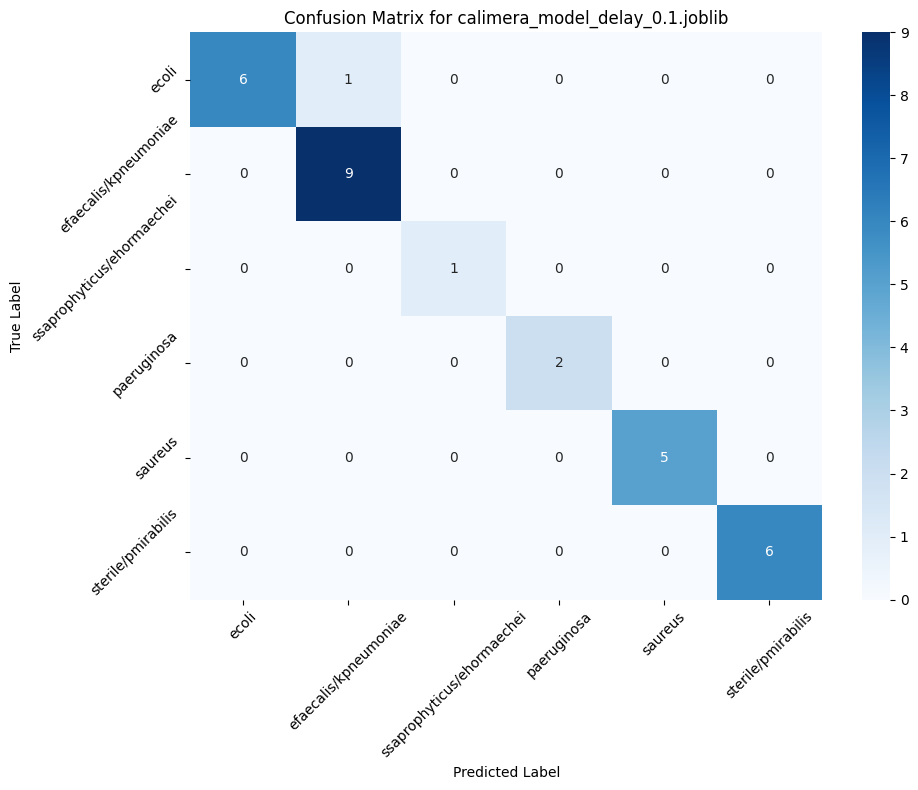

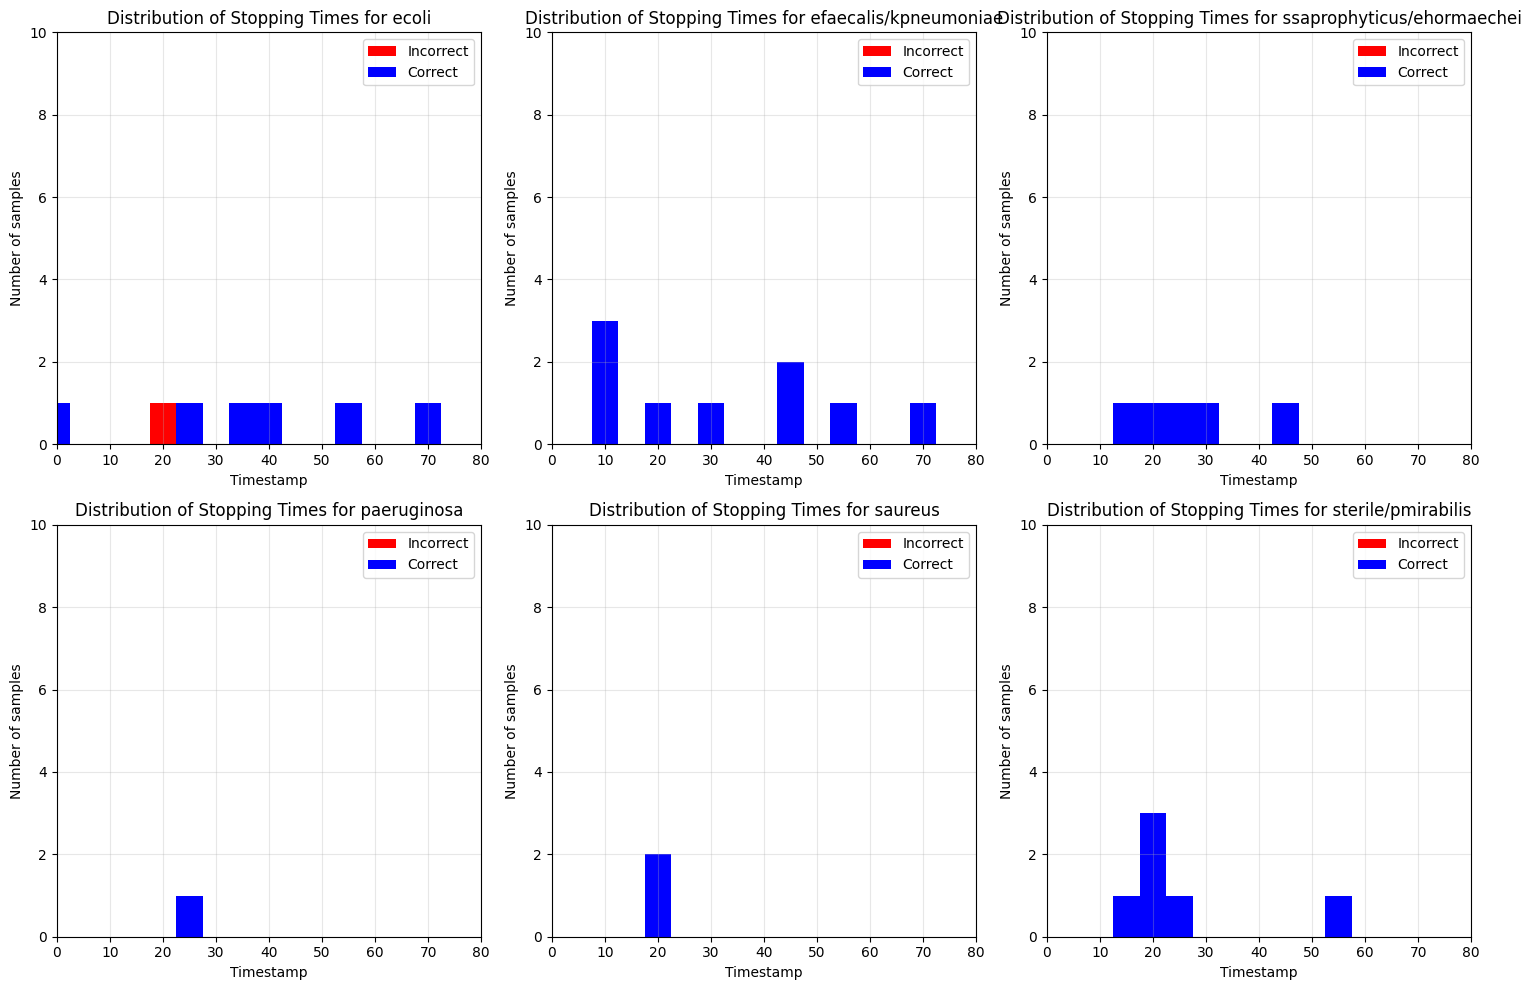

Accuracy: 0.9666666666666667
Earliness: 0.3933333333333333
Cost: 0.041199999999999994


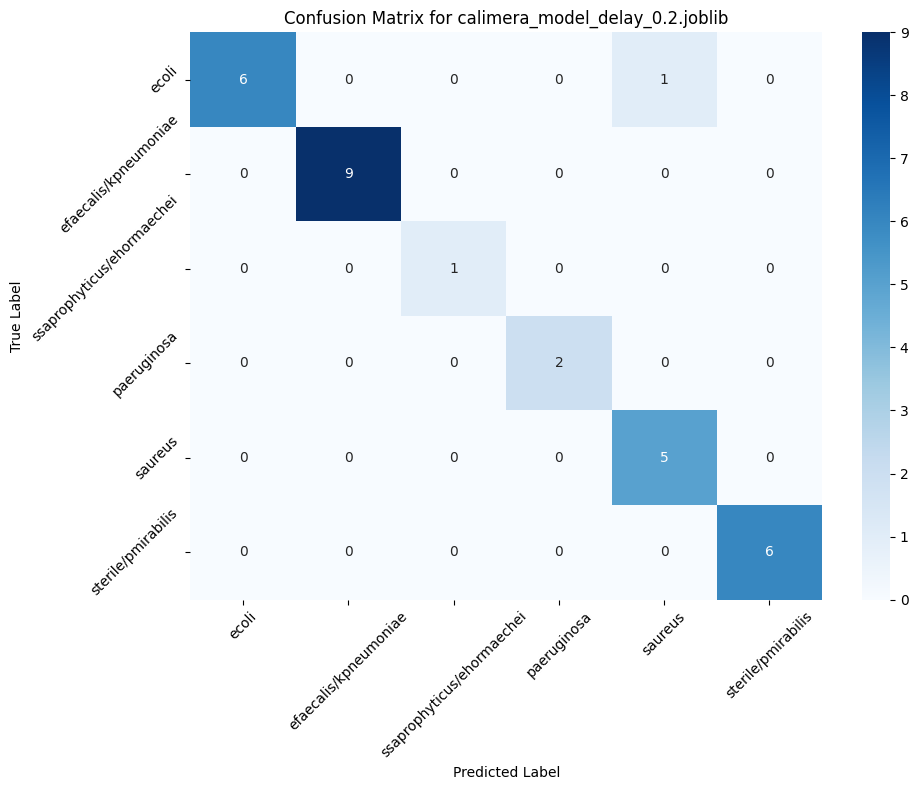

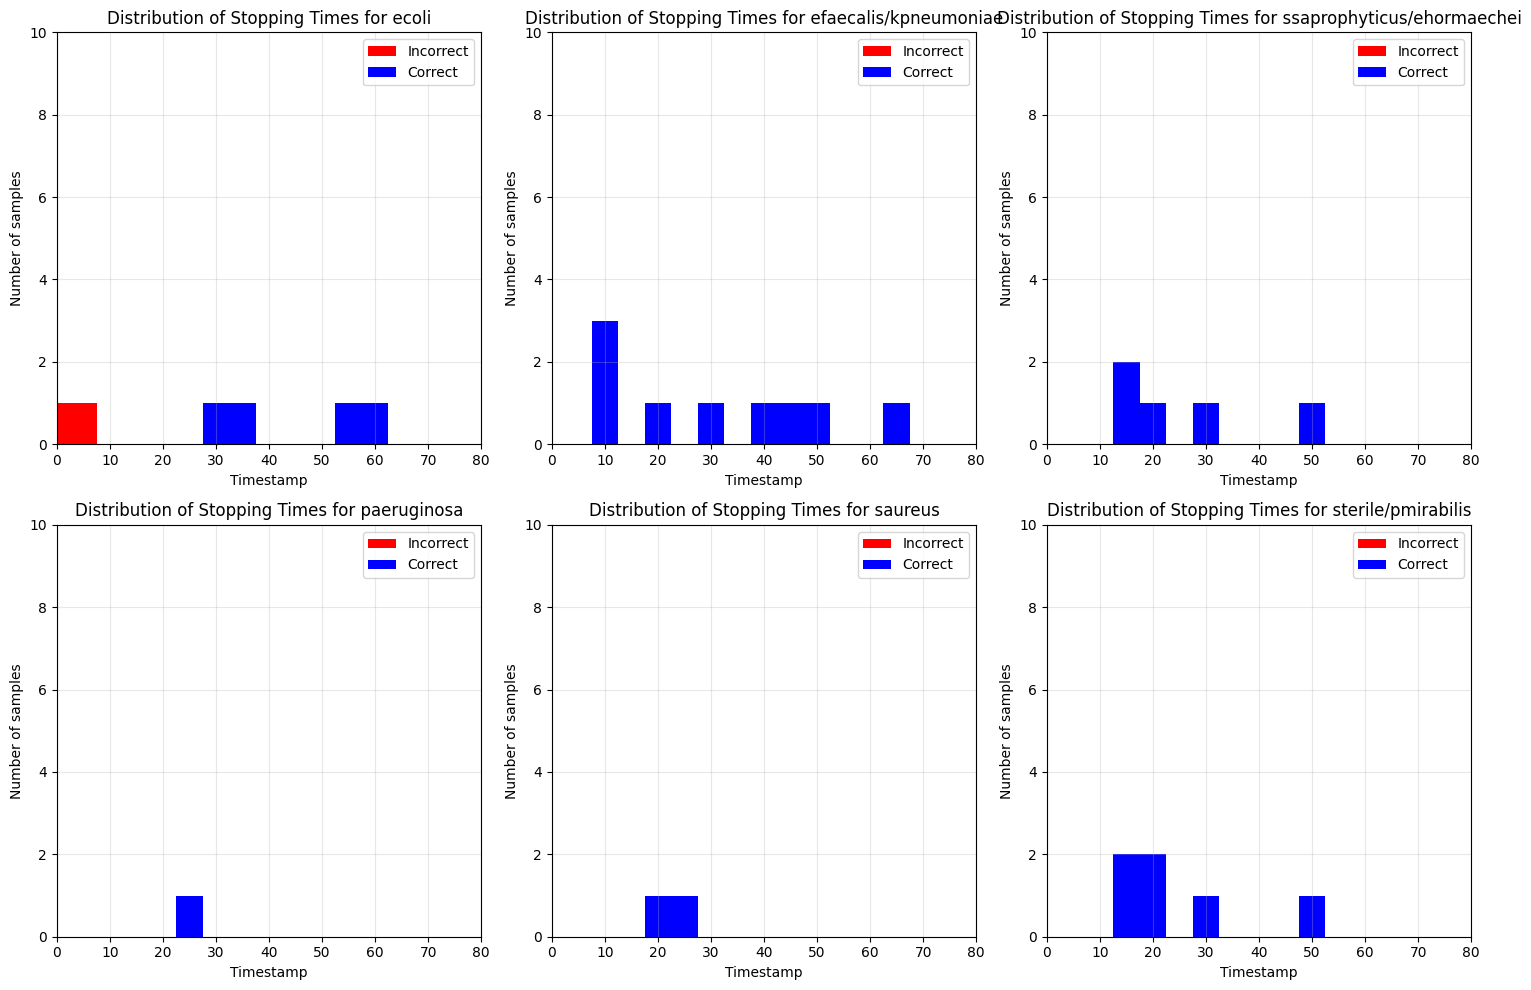

Accuracy: 0.9333333333333333
Earliness: 0.3954166666666667
Cost: 0.07852916666666665


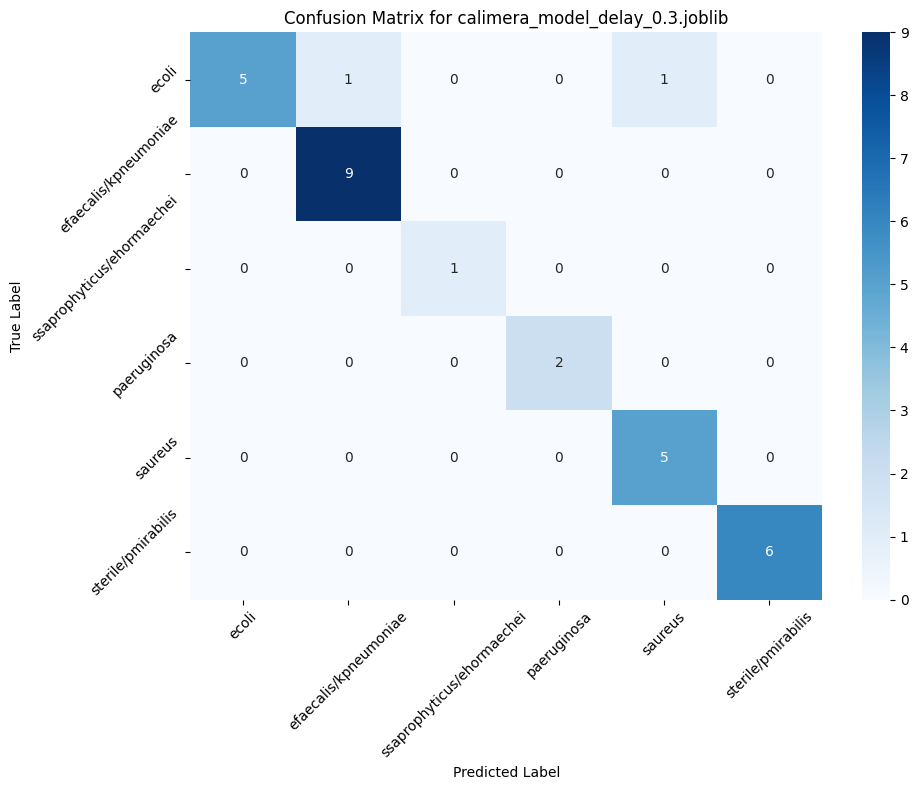

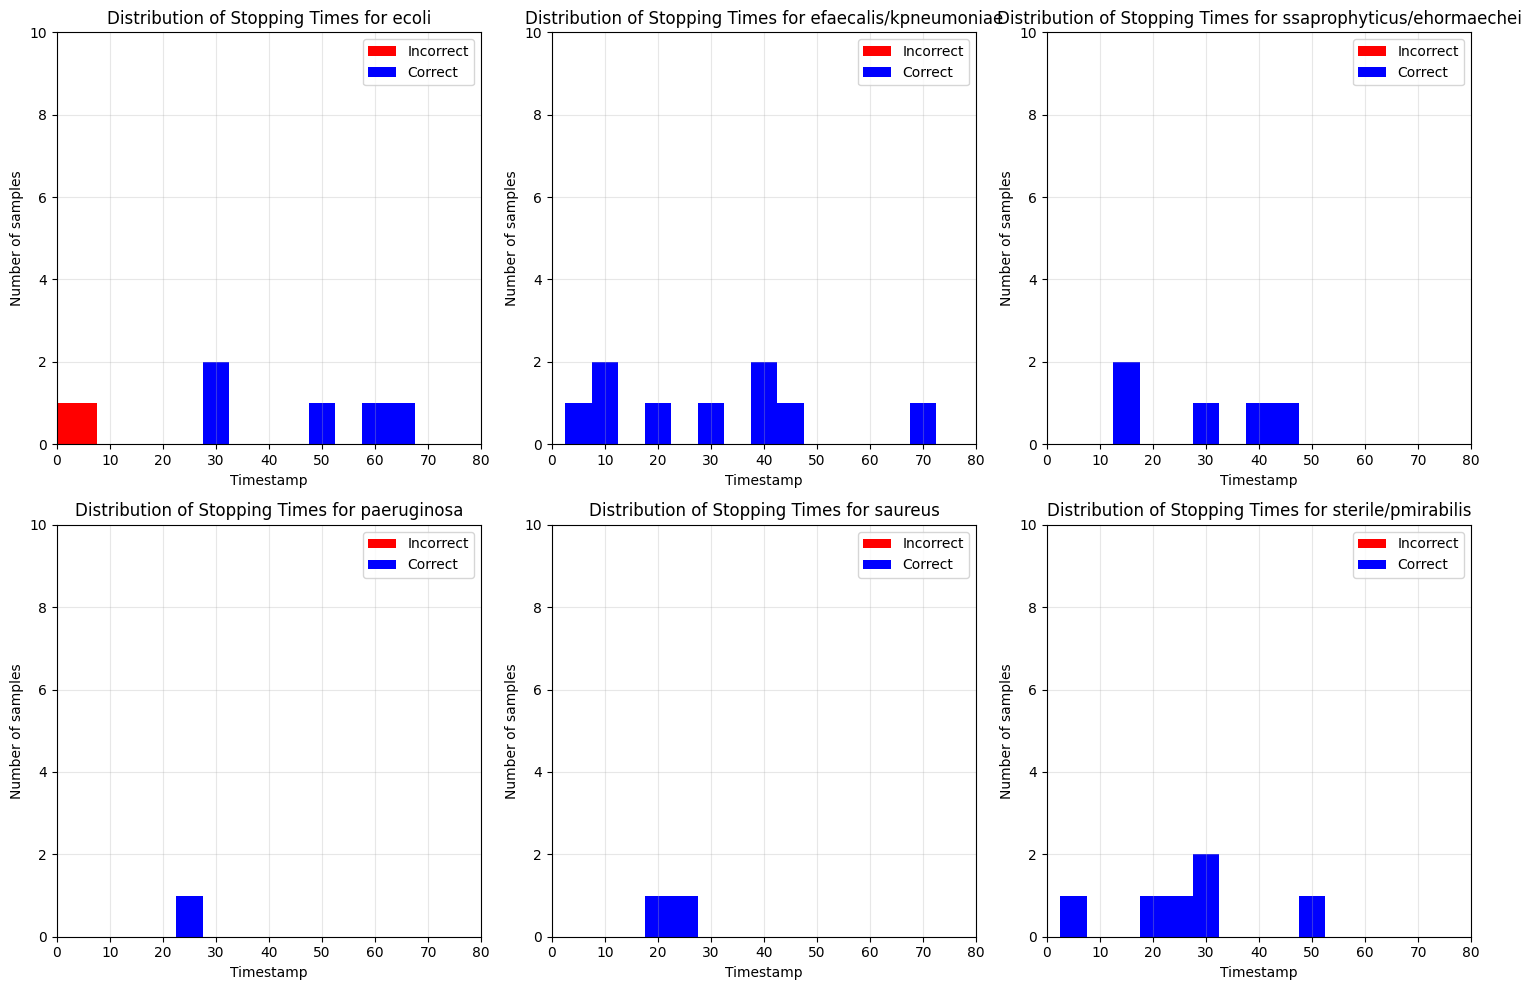

Accuracy: 0.9333333333333333
Earliness: 0.39916666666666667
Cost: 0.08263333333333332


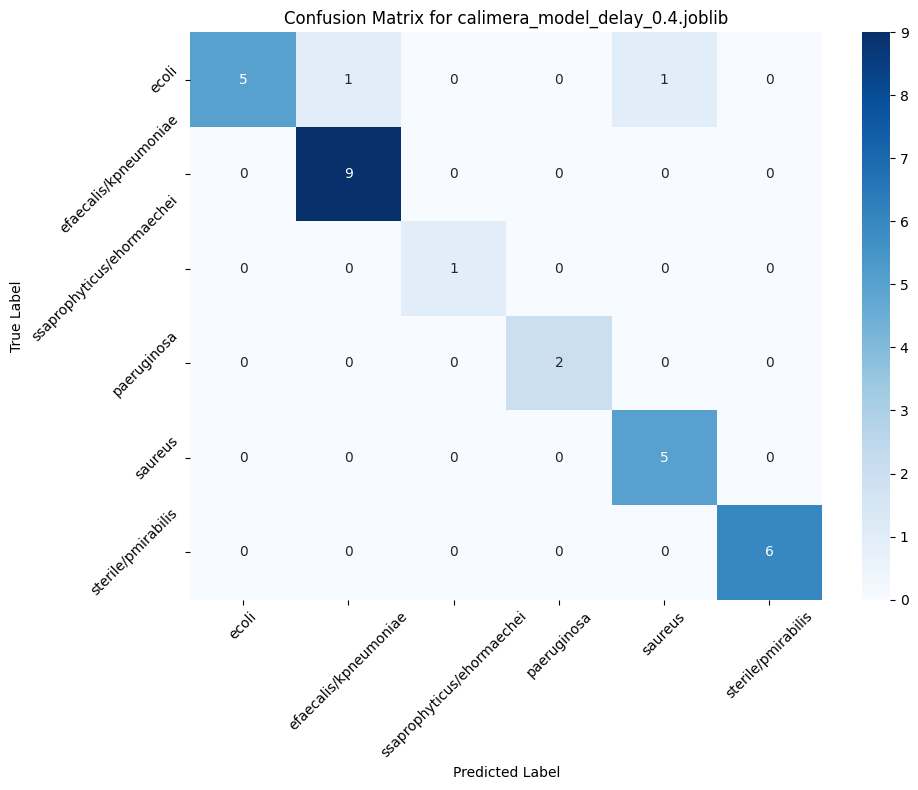

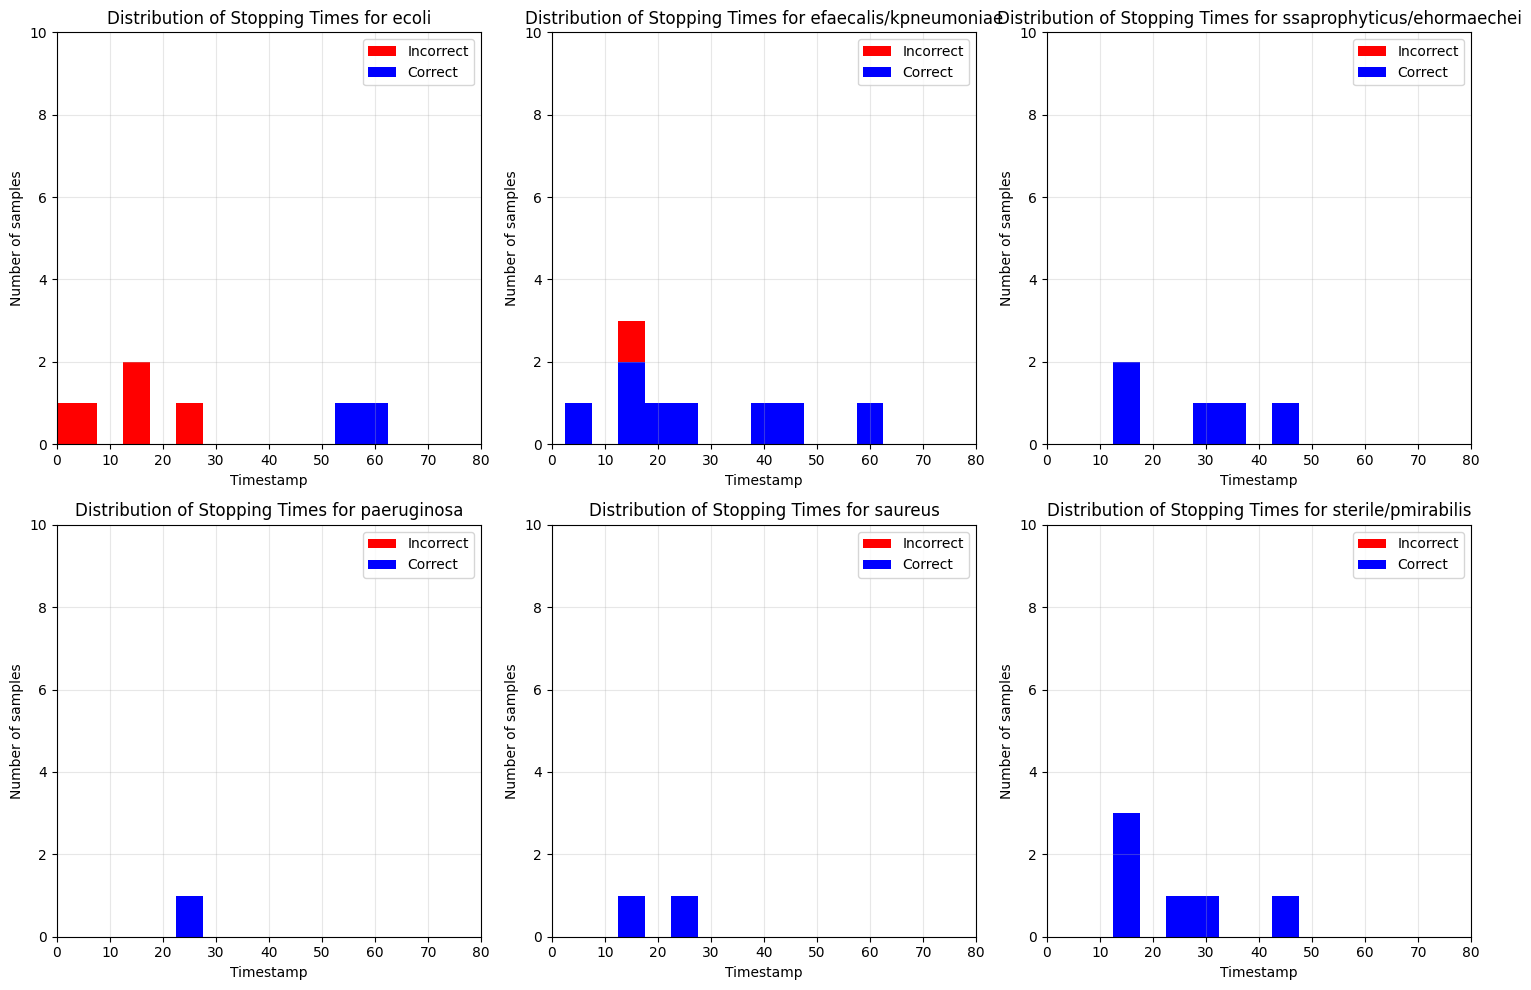

Accuracy: 0.8
Earliness: 0.34208333333333335
Cost: 0.21710416666666663


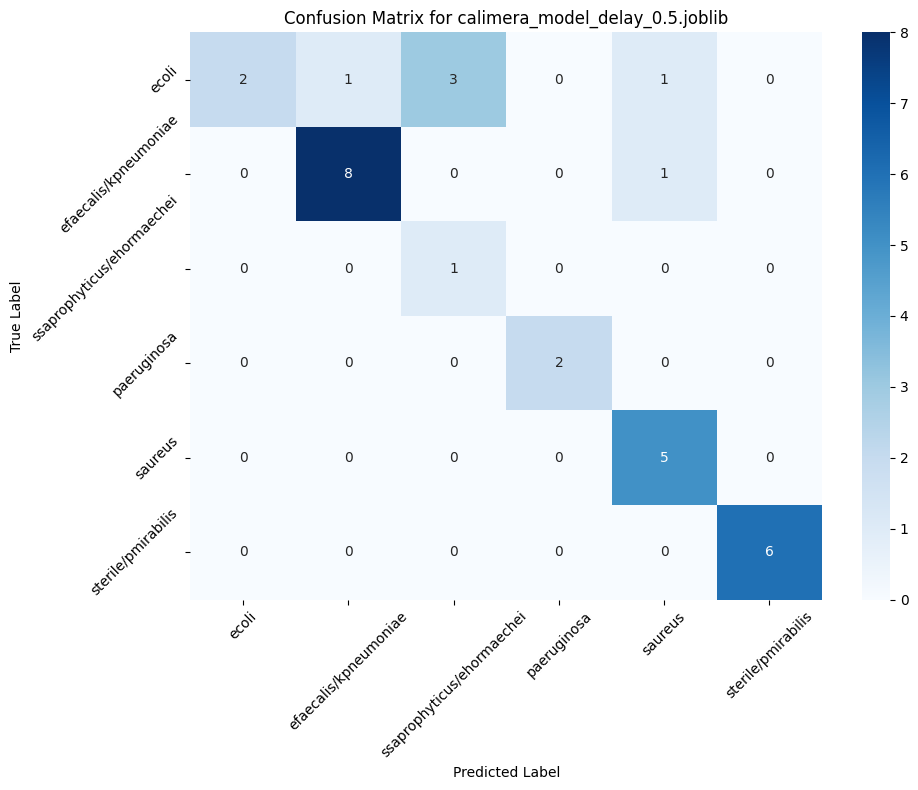

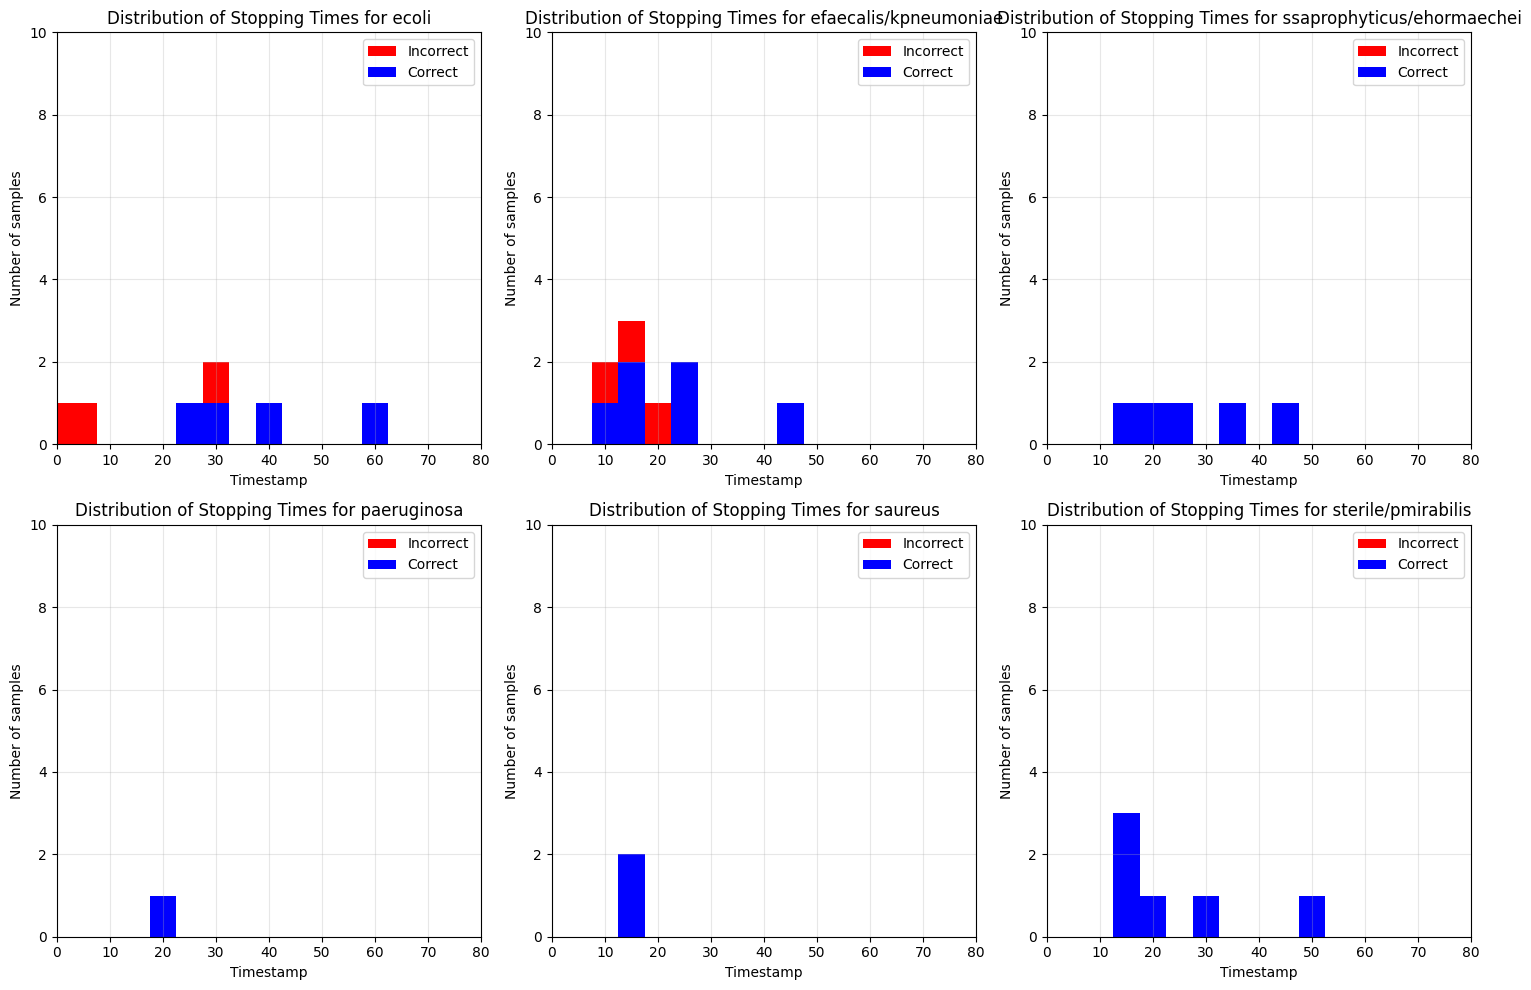

Accuracy: 0.8
Earliness: 0.32
Cost: 0.21919999999999995


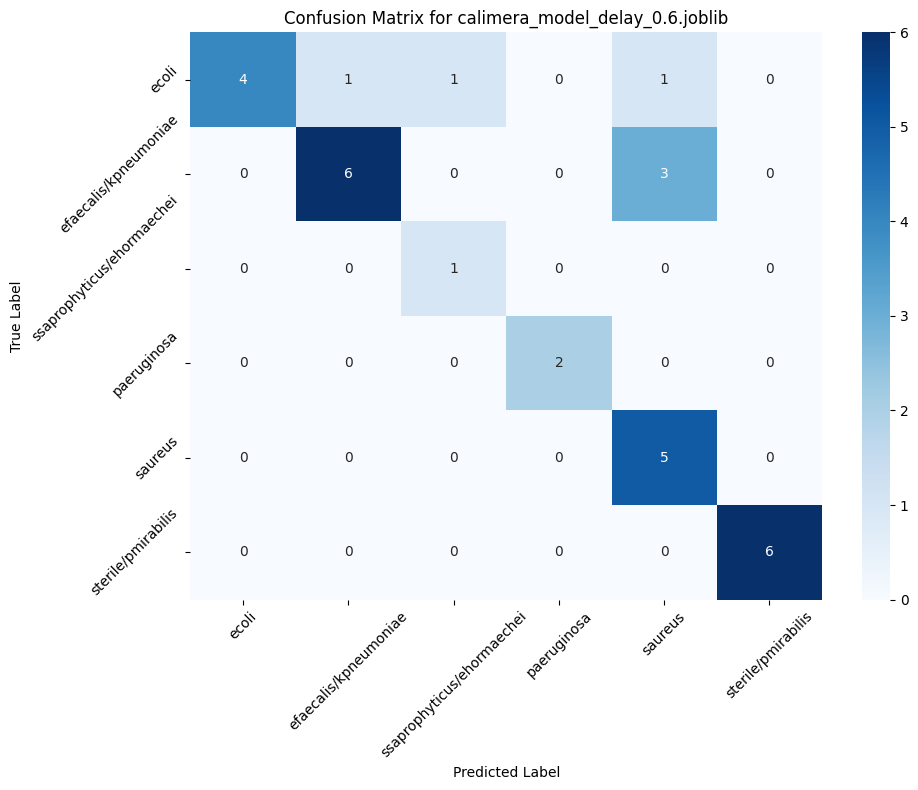

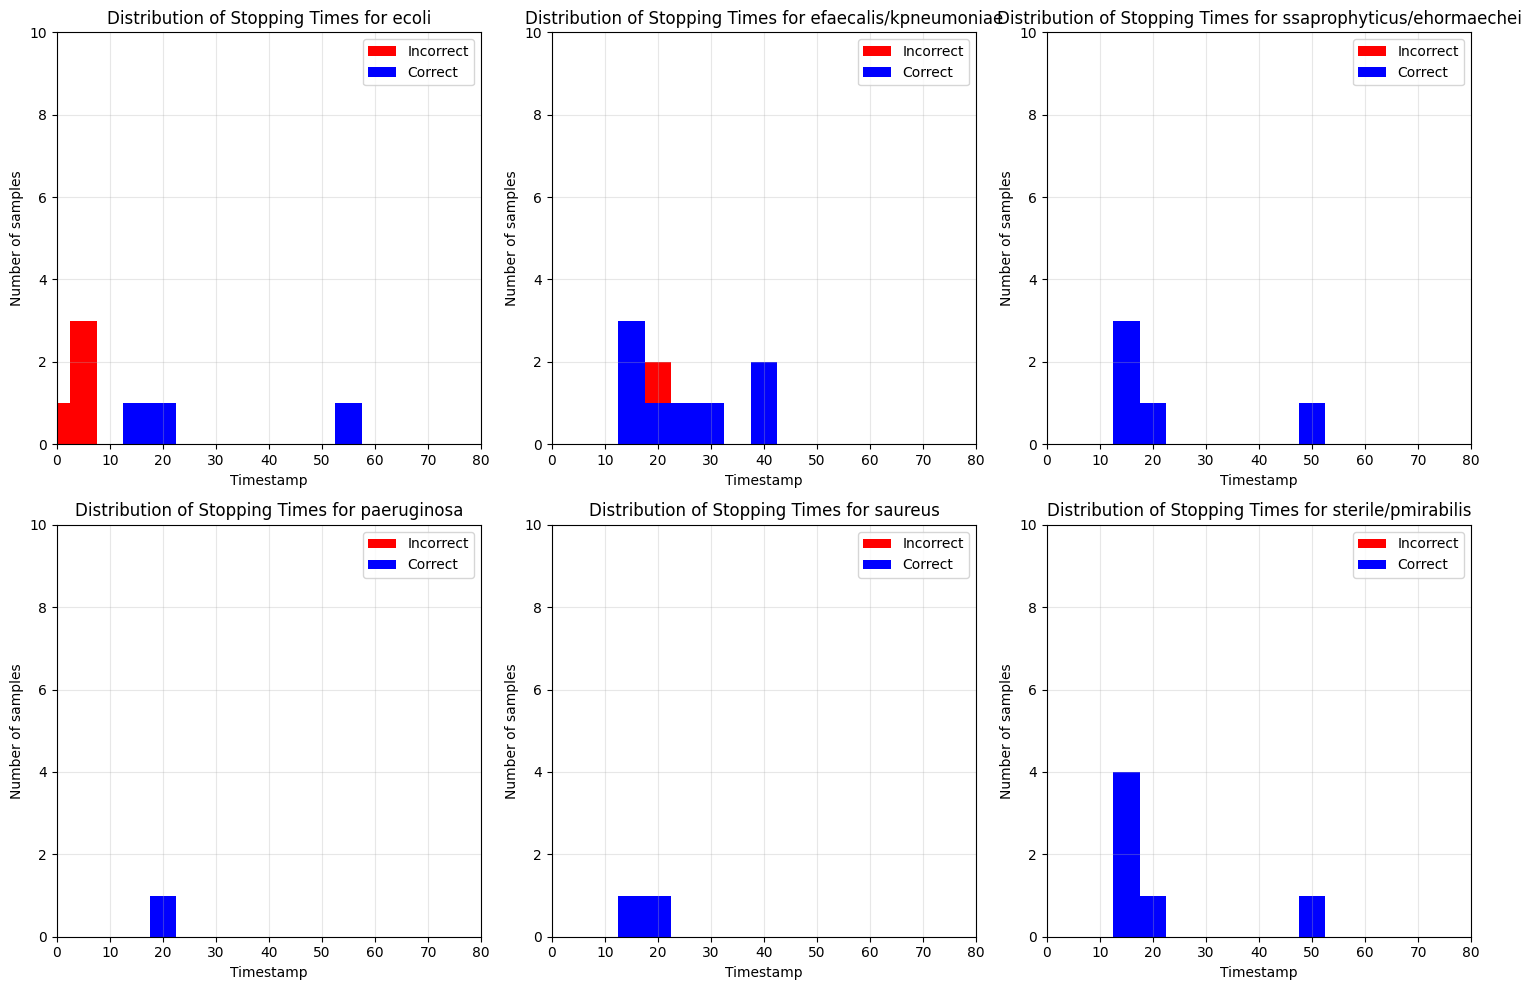

Accuracy: 0.8333333333333334
Earliness: 0.285
Cost: 0.18661666666666663


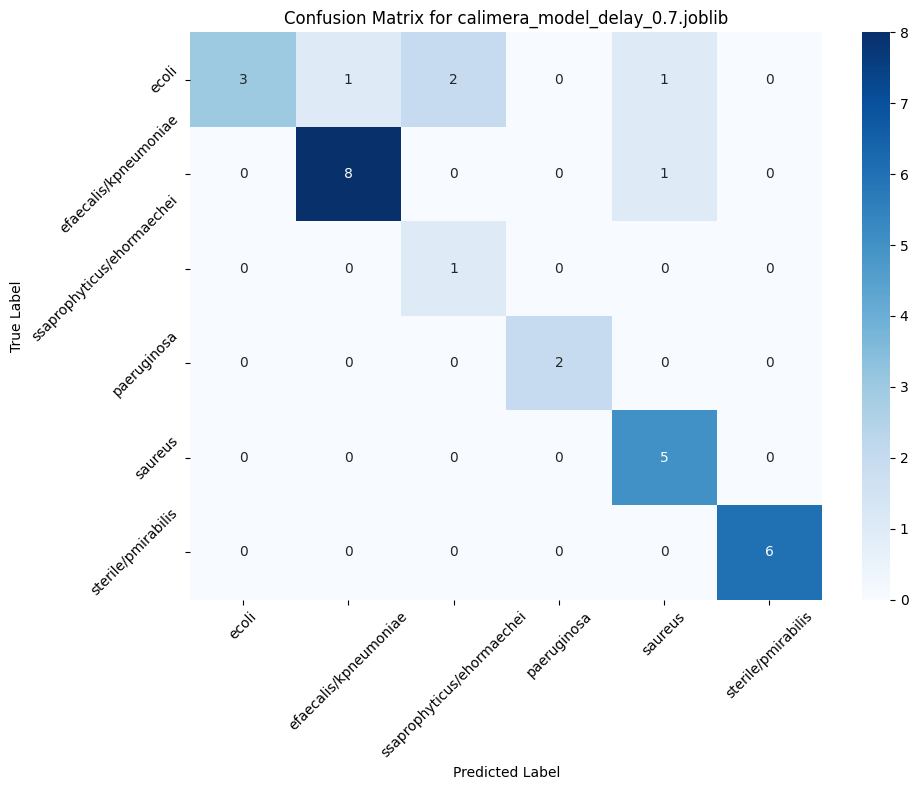

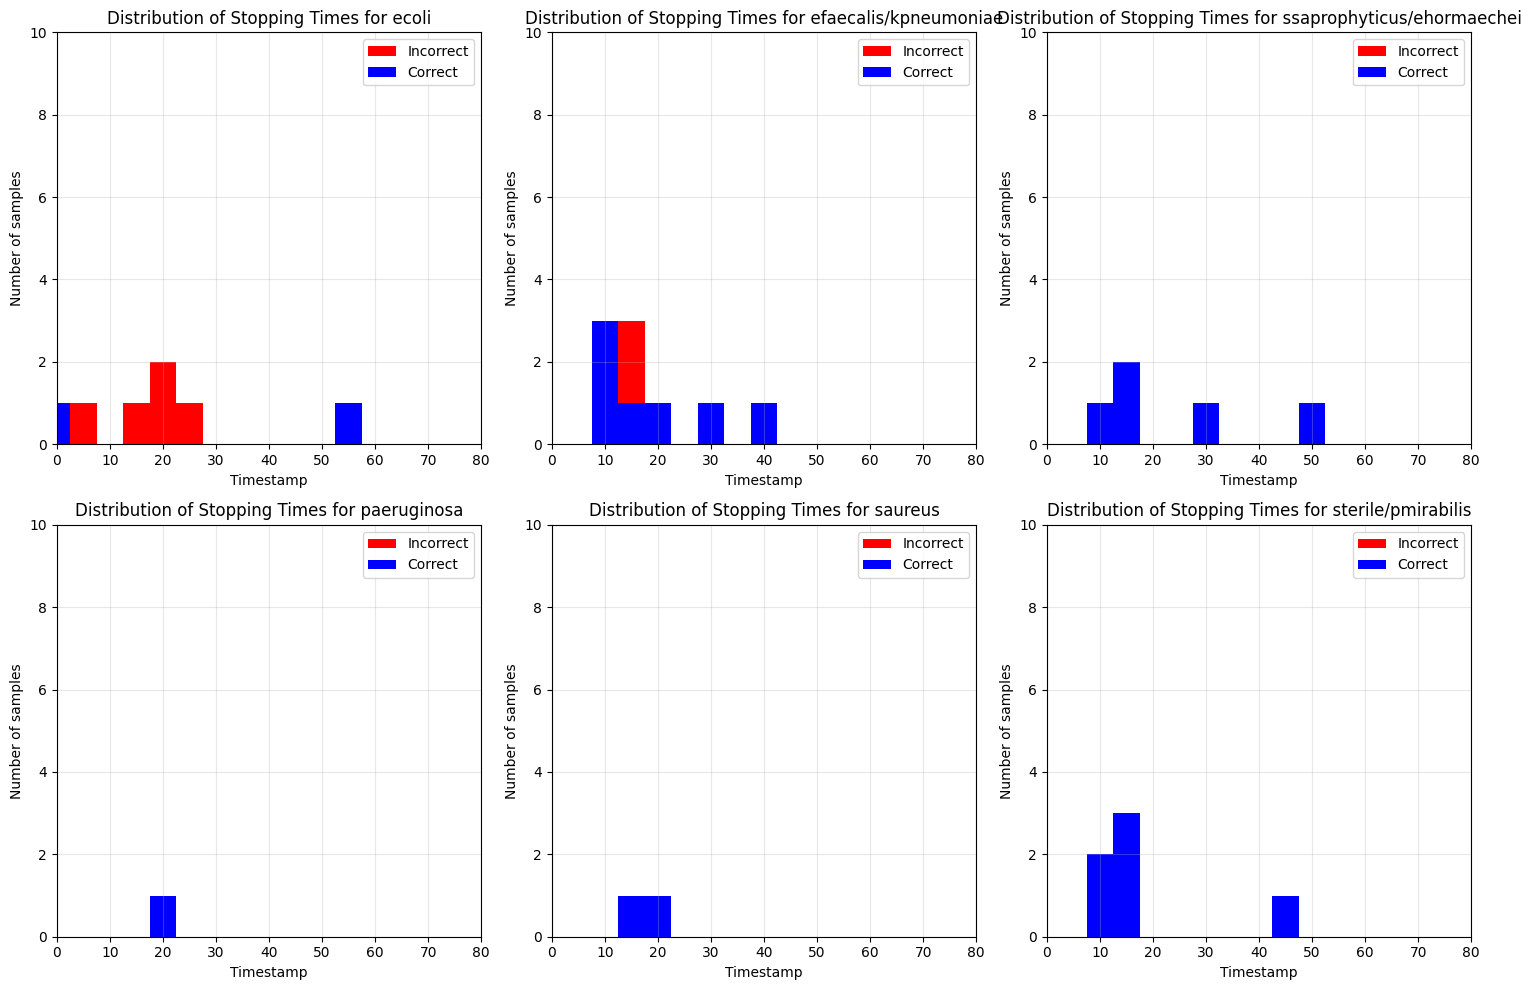

Accuracy: 0.7666666666666667
Earliness: 0.26375
Cost: 0.2544333333333333


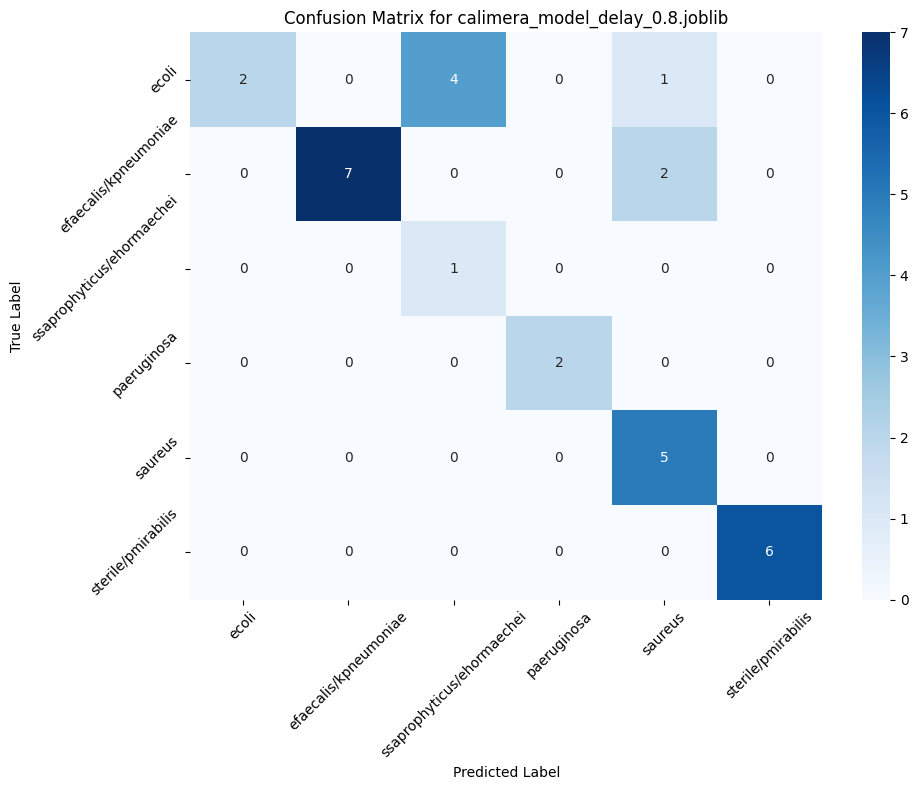

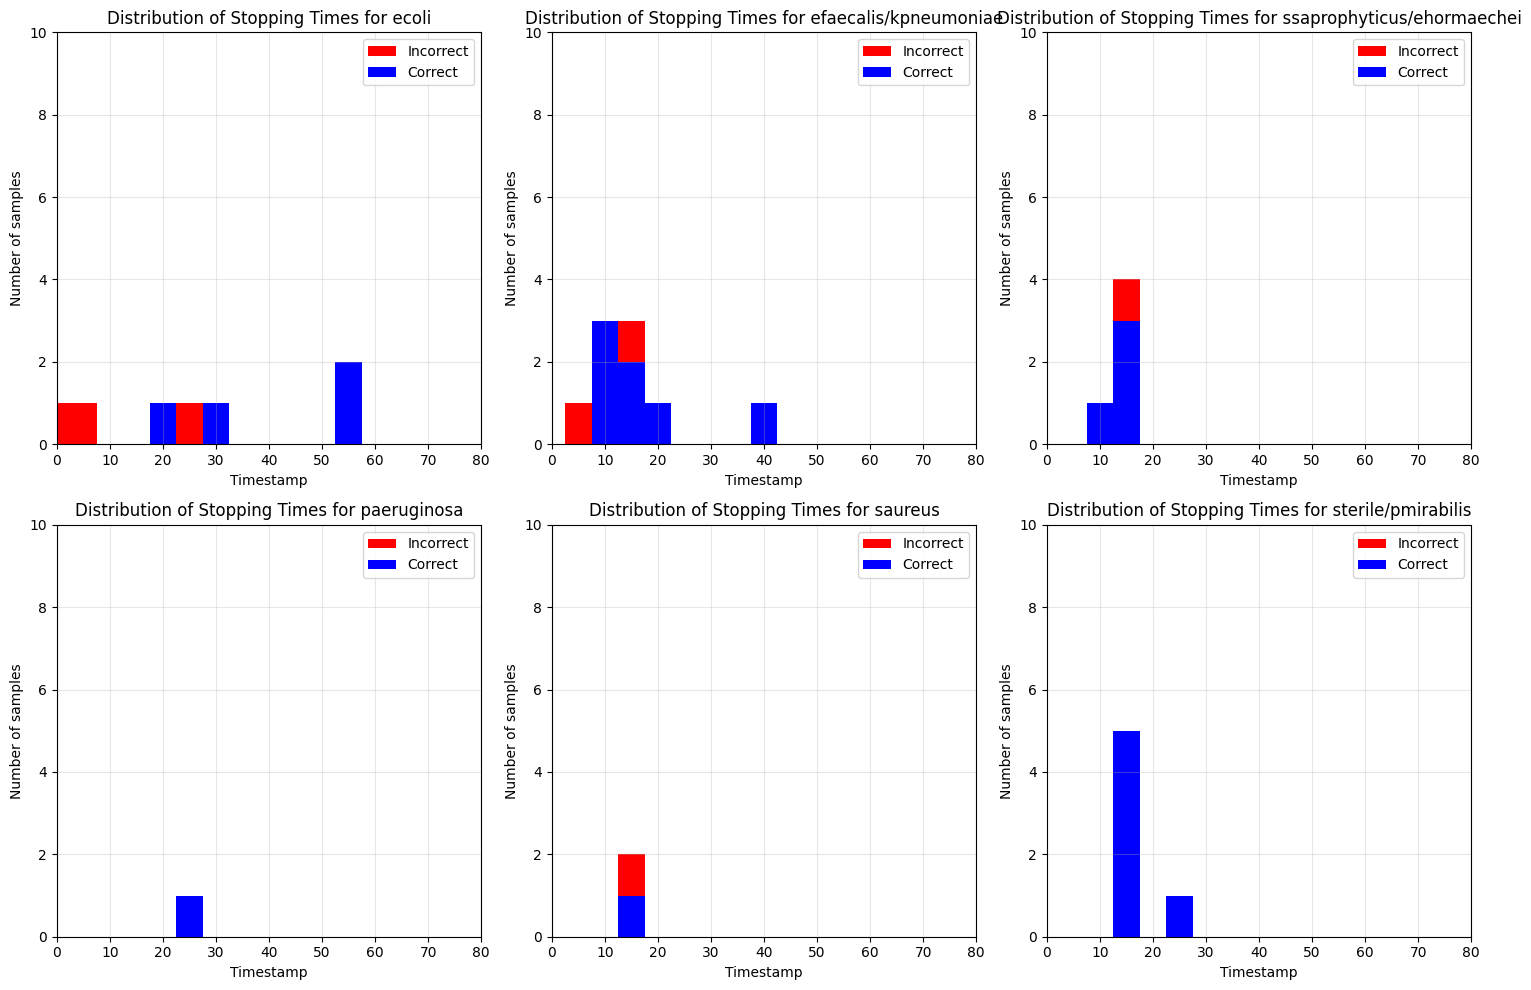

Accuracy: 0.7666666666666667
Earliness: 0.25166666666666665
Cost: 0.2559833333333333


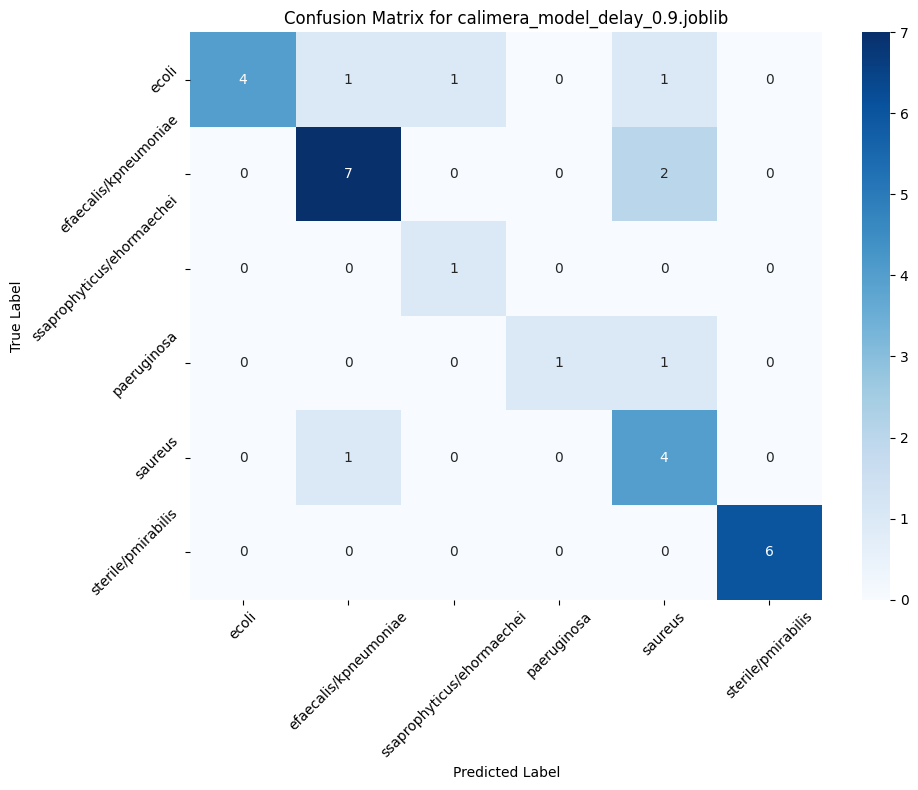

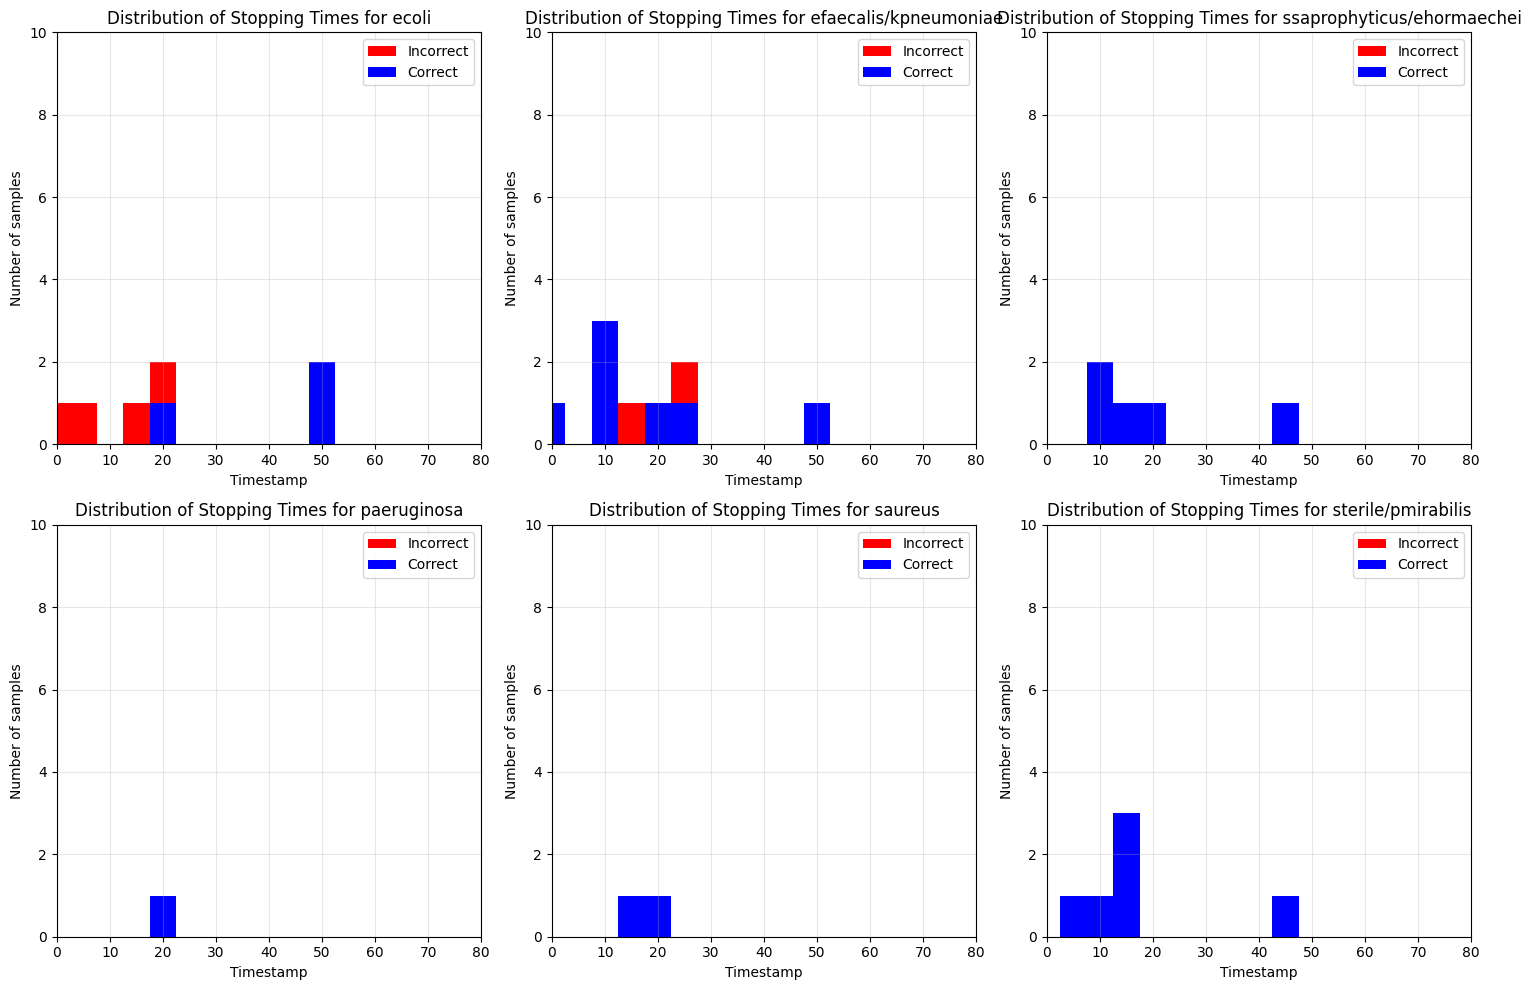

Accuracy: 0.8
Earliness: 0.27416666666666667
Cost: 0.22741666666666663


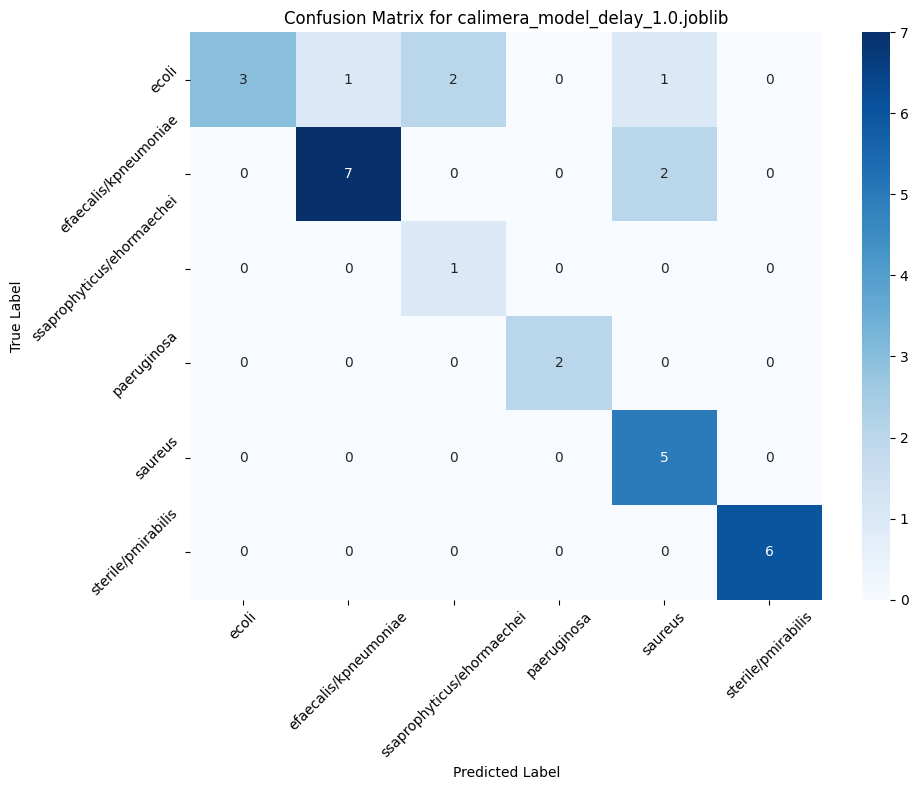

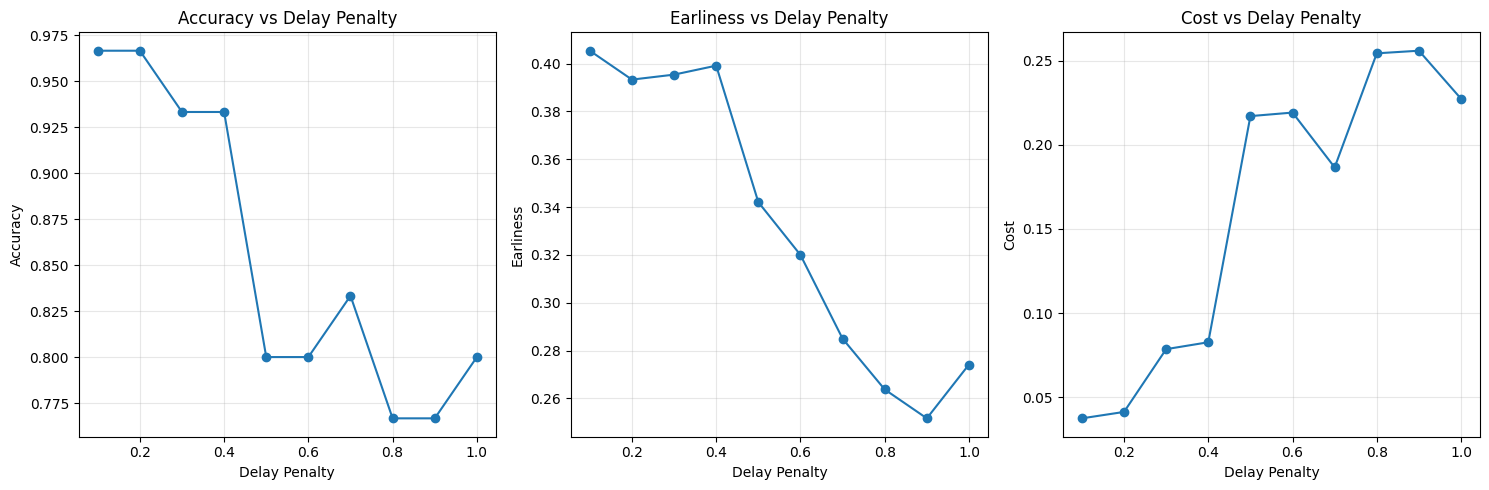

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import numpy as np

classes = ['ecoli', 'efaecalis/kpneumoniae', 'ssaprophyticus/ehormaechei', 
           'paeruginosa', 'saureus', 'sterile/pmirabilis']


models = [f for f in os.listdir('/media/storage/users/go98kef/CALIMERA/saved_models') if f.endswith('.joblib')]
root = '/media/storage/users/go98kef/CALIMERA/saved_models'
# Sort models based on the float delay number in the filename
models.sort(key=lambda x: float(x.split('_')[3].replace('delay_', '').replace('.joblib', '')))
m = 0
accuracy_scores = []
earliness_scores = []
cost_scores = []
for model in models:
    model = joblib.load(os.path.join(root, model))
    stop_timestamps, y_pred = model.test(X_test)

    bin_range = range(0, 80, 5)

    fig1, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

    class_stops_true = {class_name: [] for class_name in classes}
    class_stops_false = {class_name: [] for class_name in classes}

    # Fill dictionaries with stopping times for each class
    for stop, pred, true in zip(stop_timestamps, y_pred, y_test):
        if pred == true:
            class_stops_true[true].append(stop)
        else:
            class_stops_false[true].append(stop)

    ax1.hist([class_stops_true[classes[0]], class_stops_false[classes[0]]], bins=bin_range, align='left',
             color=['blue', 'red'], label=['Correct', 'Incorrect'], stacked=True, histtype='stepfilled')
    ax1.set_title(f'Distribution of Stopping Times for {classes[0]}')
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Number of samples')
    ax1.set_xlim(0, 80)
    ax1.set_ylim(0, 10)
    ax1.grid(True, alpha=0.3)
    ax1.legend()  # Add legend to first subplot

    ax2.hist([class_stops_true[classes[1]], class_stops_false
              [classes[1]]], bins=bin_range, align='left',
             color=['blue', 'red'], label=['Correct', 'Incorrect'], stacked=True, histtype='stepfilled')
    ax2.set_title(f'Distribution of Stopping Times for {classes[1]}')
    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Number of samples')
    ax2.set_xlim(0, 80)
    ax2.set_ylim(0, 10)
    ax2.grid(True, alpha=0.3)
    ax2.legend()  # Add legend to second subplot

    ax3.hist([class_stops_true[classes[2]], class_stops_false
              [classes[2]]], bins=bin_range, align='left', color=['blue', 'red'], label=['Correct', 'Incorrect'], stacked=True, histtype='stepfilled')
    ax3.set_title(f'Distribution of Stopping Times for {classes[2]}')
    ax3.set_xlabel('Timestamp')
    ax3.set_ylabel('Number of samples')
    ax3.set_xlim(0, 80)
    ax3.set_ylim(0, 10)
    ax3.grid(True, alpha=0.3)
    ax3.legend()  

    ax4.hist([class_stops_true[classes[3]], class_stops_false
              [classes[3]]], bins=bin_range, align='left', color=['blue', 'red'], label=['Correct', 'Incorrect'], stacked=True, histtype='stepfilled')
    ax4.set_title(f'Distribution of Stopping Times for {classes[3]}')
    ax4.set_xlabel('Timestamp')
    ax4.set_ylabel('Number of samples')
    ax4.set_xlim(0, 80)
    ax4.set_ylim(0, 10)
    ax4.grid(True, alpha=0.3)
    ax4.legend()

    ax5.hist([class_stops_true[classes[4]], class_stops_false[classes[4]]], bins=bin_range, align='left',
             color=['blue', 'red'], label=['Correct', 'Incorrect'], stacked=True, histtype='stepfilled')
    ax5.set_title(f'Distribution of Stopping Times for {classes[4]}')
    ax5.set_xlabel('Timestamp')
    ax5.set_ylabel('Number of samples')
    ax5.set_xlim(0, 80)
    ax5.set_ylim(0, 10)
    ax5.grid(True, alpha=0.3)
    ax5.legend()

    ax6.hist([class_stops_true[classes[5]], class_stops_false[classes[5]]], bins=bin_range, align='left',
             color=['blue', 'red'], label=['Correct', 'Incorrect'], stacked=True, histtype='stepfilled')
    ax6.set_title(f'Distribution of Stopping Times for {classes[5]}')
    ax6.set_xlabel('Timestamp')
    ax6.set_ylabel('Number of samples')
    ax6.set_xlim(0, 80)
    ax6.set_ylim(0, 10)
    ax6.grid(True, alpha=0.3)
    ax6.legend()

    plt.tight_layout()
    plt.show()

    delay_penalty = (m+1)/10
    accuracy = accuracy_score(y_test, y_pred)
    earliness = sum(stop_timestamps) / (X_test.shape[-1] * X_test.shape[0])
    cost = 1.0 - accuracy + delay_penalty/10 * earliness
    print(f'Accuracy: {accuracy}\nEarliness: {earliness}\nCost: {cost}')

    accuracy_scores.append(accuracy)
    earliness_scores.append(earliness)
    cost_scores.append(cost)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, 
                yticklabels=classes)
    plt.title(f'Confusion Matrix for {models[m]}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    m += 1

# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Get delay penalties from model names
delay_penalties = [float(model.split('_')[3].replace('delay_', '').replace('.joblib', '')) for model in models]

# Plot accuracy
ax1.plot(delay_penalties, accuracy_scores, marker='o')
ax1.set_xlabel('Delay Penalty')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Delay Penalty')
ax1.grid(True, alpha=0.3)

# Plot earliness
ax2.plot(delay_penalties, earliness_scores, marker='o')
ax2.set_xlabel('Delay Penalty')
ax2.set_ylabel('Earliness')
ax2.set_title('Earliness vs Delay Penalty')
ax2.grid(True, alpha=0.3)

# Plot cost
ax3.plot(delay_penalties, cost_scores, marker='o')
ax3.set_xlabel('Delay Penalty')
ax3.set_ylabel('Cost')
ax3.set_title('Cost vs Delay Penalty')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()